# Diffusion Model (with Images 32x32)

Our team adapted the stable diffusion code provided by the following source code:
- Seachaos. (2023, April 10). *Make Diffusion model from scratch (easy way to implement quick diffusion model)*. https://tree.rocks/make-diffusion-model-from-scratch-easy-way-to-implement-quick-diffusion-model-e60d18fd0f2e

We started with downsizing our images to 32x32 for this model. This is generally done to have all images in the same dimensions and also to make training easier and less costly as the images are smaller. We did this to test our first diffusion model. This performed better than GANs with low data but only generated pixelized blobs of blue colors.

### Set-Up

We ran this code in Google Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np

from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers

import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf

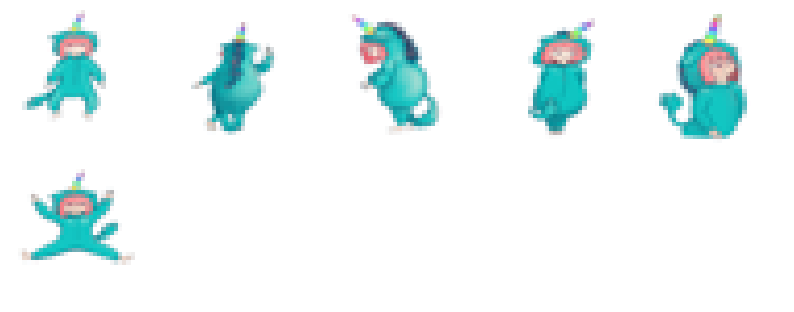

In [ ]:
# Load your image dataset and resize each image
imgs = [np.array(Image.open(path).resize((32,32))) for path in glob.glob("/data/*.jpg")]
num_imgs_to_preview = min(6, len(imgs))

# Preprocess your image data
X_train = np.array(imgs) / 127.5 - 1.0

# Function to normalize images
def cvtImg(img):
    img = img - img.min()
    img = img / img.max()
    return img.astype(np.float32)

# Show examples of your dataset
def show_examples(x):
    plt.figure(figsize=(10, 10))
    for i in range(min(25, len(x))):
        plt.subplot(5, 5, i+1)
        img = cvtImg(x[i])
        plt.imshow(img)
        plt.axis('off')

show_examples(X_train)

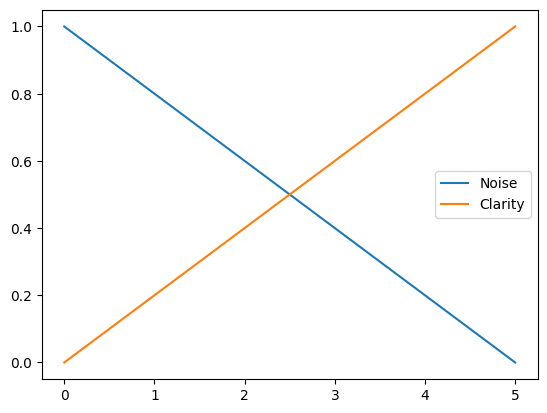

In [ ]:
IMG_SIZE = 32     # input image size, CIFAR-10 is 32x32
BATCH_SIZE = 2  # for training batch size
timesteps = 5    # how many steps for a noisy image into clear
time_bar = 1 - np.linspace(0, 1.0, timesteps + 1) # linspace for timesteps

plt.plot(time_bar, label='Noise')
plt.plot(1 - time_bar, label='Clarity')
plt.legend()

### Noise Process Overview

See our train images with different levels of noise added. 32x32 makes the images alread very blurry at the start.

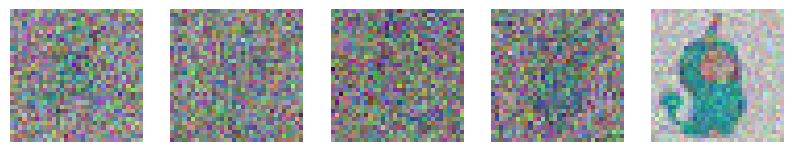

In [ ]:
def forward_noise(x, t):
    a = time_bar[t]      # base on t
    b = time_bar[t + 1]  # image for t + 1

    noise = np.random.normal(size=x.shape)  # noise mask
    a = a.reshape((-1, 1, 1, 1))
    b = b.reshape((-1, 1, 1, 1))
    img_a = x * (1 - a) + noise * a
    img_b = x * (1 - b) + noise * b
    return img_a, img_b

def generate_ts(num):
    return np.random.randint(0, timesteps, size=num)

# t = np.full((5,), timesteps - 1) # if you want see clarity
# t = np.full((5,), 0)             # if you want see noisy
t = generate_ts(5)             # random for training data
a, b = forward_noise(X_train[:5], t)
show_examples(a)

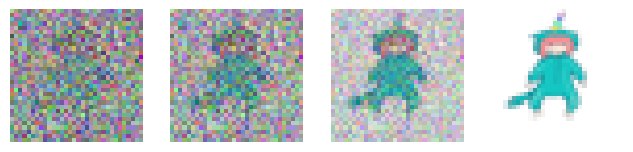

In [ ]:
t = array = np.arange(1, 5)            # random for training data
a, b = forward_noise(X_train[:1], t)
show_examples(b)

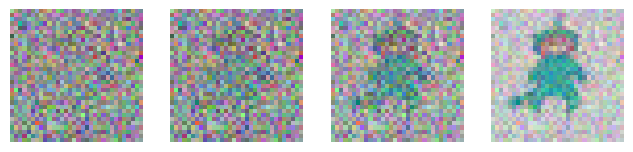

In [ ]:
show_examples(a)

### Prepare Blocks for Model Structure

In [ ]:
def block(x_img, x_ts):
    x_parameter = layers.Conv2D(128, kernel_size=3, padding='same')(x_img)
    x_parameter = layers.Activation('relu')(x_parameter)

    time_parameter = layers.Dense(128)(x_ts)
    time_parameter = layers.Activation('relu')(time_parameter)
    time_parameter = layers.Reshape((1, 1, 128))(time_parameter)
    x_parameter = x_parameter * time_parameter

    # -----
    x_out = layers.Conv2D(128, kernel_size=3, padding='same')(x_img)
    x_out = x_out + x_parameter
    x_out = layers.LayerNormalization()(x_out)
    x_out = layers.Activation('relu')(x_out)

    return x_out

In [ ]:
def make_model():
    x = x_input = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='x_input')

    x_ts = x_ts_input = layers.Input(shape=(1,), name='x_ts_input')
    x_ts = layers.Dense(192)(x_ts)
    x_ts = layers.LayerNormalization()(x_ts)
    x_ts = layers.Activation('relu')(x_ts)

    # ----- left ( down ) -----
    x = x32 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)

    x = x16 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)

    x = x8 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)

    x = x4 = block(x, x_ts)

    # ----- MLP -----
    x = layers.Flatten()(x)
    x = layers.Concatenate()([x, x_ts])
    x = layers.Dense(128)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Dense(4 * 4 * 32)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Reshape((4, 4, 32))(x)

    # ----- right ( up ) -----
    x = layers.Concatenate()([x, x4])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)

    x = layers.Concatenate()([x, x8])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)

    x = layers.Concatenate()([x, x16])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)

    x = layers.Concatenate()([x, x32])
    x = block(x, x_ts)

    # ----- output -----
    x = layers.Conv2D(3, kernel_size=1, padding='same')(x)
    model = tf.keras.models.Model([x_input, x_ts_input], x)
    return model

model = make_model()
# model.summary()

### Run Model

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0008)
loss_func = tf.keras.losses.MeanAbsoluteError()
model.compile(loss=loss_func, optimizer=optimizer)


  0%|          | 0/5 [00:00<?, ?it/s]

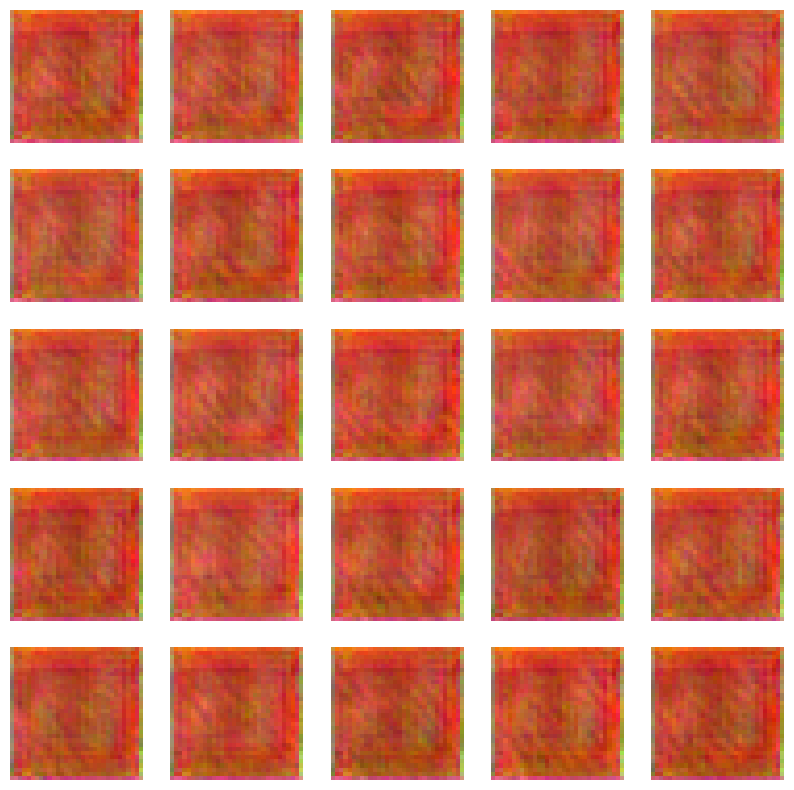

In [ ]:
def predict(x_idx=None):
    x = np.random.normal(size=(32, IMG_SIZE, IMG_SIZE, 3))
    for i in trange(timesteps):
        t = i
        x = model.predict([x, np.full((32), t)], verbose=0)
    show_examples(x)

predict()


  0%|          | 0/5 [00:00<?, ?it/s]

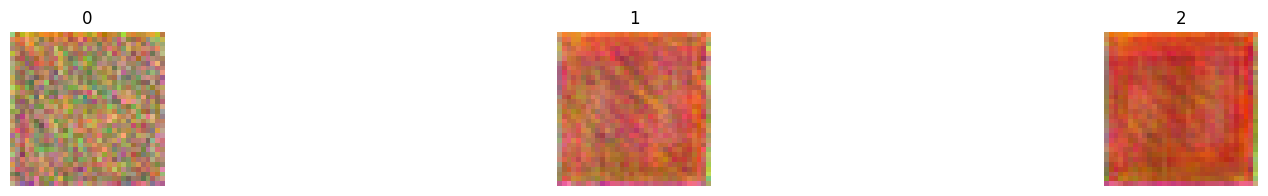

In [ ]:
def predict_step():
    xs = []
    x = np.random.normal(size=(8, IMG_SIZE, IMG_SIZE, 3))

    for i in trange(timesteps):
        t = i
        x = model.predict([x, np.full((8),  t)], verbose=0)
        if i % 2 == 0:
            xs.append(x[0])

    plt.figure(figsize=(20, 2))
    for i in range(len(xs)):
        plt.subplot(1, len(xs), i+1)
        plt.imshow(cvtImg(xs[i]))
        plt.title(f'{i}')
        plt.axis('off')

predict_step()


In [ ]:
def train_one(x_img):
    x_ts = generate_ts(len(x_img))
    x_a, x_b = forward_noise(x_img, x_ts)
    loss = model.train_on_batch([x_a, x_ts], x_b)
    return loss


In [ ]:
def train(R=4):
    bar = trange(R)
    total = 100
    for i in bar:
        for j in range(total):
            x_img = X_train[np.random.randint(len(X_train), size=BATCH_SIZE)]
            loss = train_one(x_img)
            pg = (j / total) * 100
            if j % 5 == 0:
                bar.set_description(f'loss: {loss:.5f}, p: {pg:.2f}%')


### Final Outputs

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

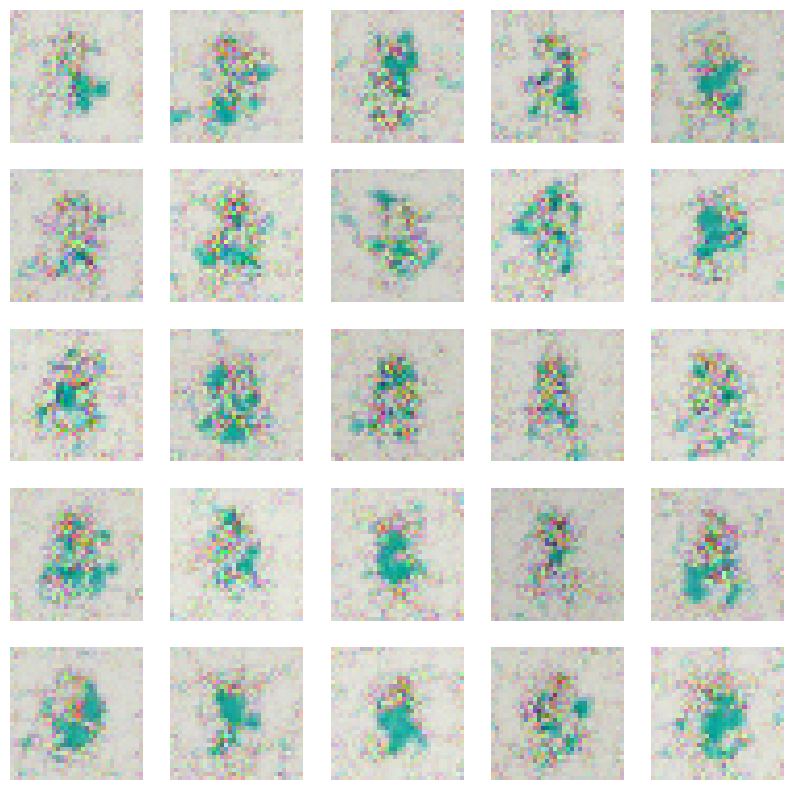

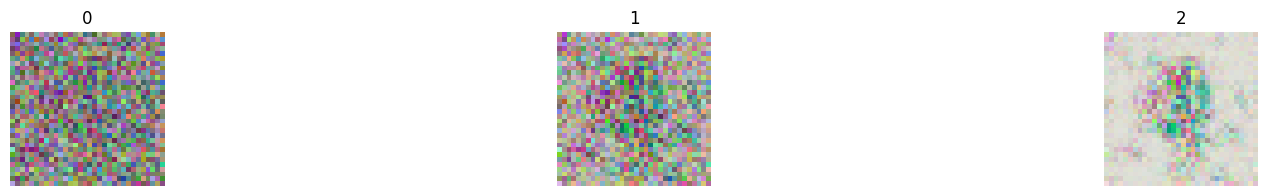

In [ ]:
for _ in range(1):
    train()
    # reduce learning rate for next training
    model.optimizer.learning_rate = max(0.000001, model.optimizer.learning_rate * 0.9)

    # show result
    predict()
    predict_step()
    plt.show()
